# Setup Environment

In [16]:
import findspark
findspark.init('/Users/Zoe/spark-2.1.0-bin-hadoop2.7/')
from pyspark import SparkContext 
from pyspark.sql import SQLContext 
from pyspark.mllib.recommendation import ALS
sc = SparkContext(appName="BuildProductRecommendations")
sqlContext = SQLContext(sc)

# Read Data

In [2]:
import pandas as pd
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path,n_rows=10):
    i = 0
    df = {}
    for d in parse(path):
        if i < n_rows:
            df[i] = d 
            i += 1
        else:
            break
    return pd.DataFrame.from_dict(df, orient='index')

## Sampling data 

In [3]:
# calculate reading time
from time import time
start = time()
# df = getDF('reviews_Kindle_Store_5.json.gz',982619)
n_prod_review_df = getDF('reviews_Kindle_Store_5.json.gz',80000)
end = time()
print('elapsed time is: %s' % (end - start))

elapsed time is: 15.1039409637


In [4]:
n_prod_review_df.head(3)

,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A1F6404F1VG29J,B000F83SZQ,Avidreader,"[0, 0]",1399248000,I enjoy vintage books and movies so I enjoyed ...,5.0,"05 5, 2014",Nice vintage story
1,AN0N05A9LIJEQ,B000F83SZQ,critters,"[2, 2]",1388966400,This book is a reissue of an old one; the auth...,4.0,"01 6, 2014",Different...
2,A795DMNCJILA6,B000F83SZQ,dot,"[2, 2]",1396569600,This was a fairly interesting read. It had ol...,4.0,"04 4, 2014",Oldie


# Transform data format

In [5]:
n_prod_review_df['reviewTime'] = pd.to_datetime(n_prod_review_df['reviewTime'], format='%m %d, %Y')

In [6]:
n_prod_review_df['reviewYear'] = n_prod_review_df.reviewTime.dt.year
n_prod_review_df['reviewMonth'] = n_prod_review_df.reviewTime.dt.month
n_prod_review_df['reviewDay'] = n_prod_review_df.reviewTime.dt.day

In [7]:
n_prod_review_df.head(2)

,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary,reviewYear,reviewMonth,reviewDay
0,A1F6404F1VG29J,B000F83SZQ,Avidreader,"[0, 0]",1399248000,I enjoy vintage books and movies so I enjoyed ...,5.0,2014-05-05,Nice vintage story,2014,5,5
1,AN0N05A9LIJEQ,B000F83SZQ,critters,"[2, 2]",1388966400,This book is a reissue of an old one; the auth...,4.0,2014-01-06,Different...,2014,1,6


In [8]:
print(n_prod_review_df.head(2)['reviewText'].tolist()[0])

I enjoy vintage books and movies so I enjoyed reading this book.  The plot was unusual.  Don't think killing someone in self-defense but leaving the scene and the body without notifying the police or hitting someone in the jaw to knock them out would wash today.Still it was a good read for me.


In [9]:
print(n_prod_review_df.head(2)['reviewText'].tolist()[1])

This book is a reissue of an old one; the author was born in 1910. It's of the era of, say, Nero Wolfe. The introduction was quite interesting, explaining who the author was and why he's been forgotten; I'd never heard of him.The language is a little dated at times, like calling a gun a &#34;heater.&#34;  I also made good use of my Fire's dictionary to look up words like &#34;deshabille&#34; and &#34;Canarsie.&#34; Still, it was well worth a look-see.


# Explore data in Pandas

In [10]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
color = sns.color_palette()
#matplotlib.style.use('ggplot')
%matplotlib inline

/Users/Zoe/anaconda/envs/NN_tutorial/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


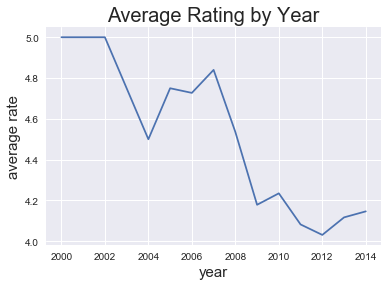

In [12]:
avg_rate = n_prod_review_df.groupby('reviewYear')['overall'].mean()
plt.ylabel('average rate',fontsize=15)
plt.xlabel('year',fontsize=15)
plt.title('Average Rating by Year',fontsize=20)
plt.plot(avg_rate.index,avg_rate)

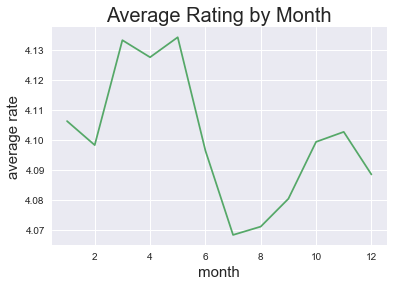

In [17]:
avg_rate = n_prod_review_df.groupby('reviewMonth')['overall'].mean()
plt.ylabel('average rate',fontsize=15)
plt.xlabel('month',fontsize=15)
plt.title('Average Rating by Month',fontsize=20)
plt.plot(avg_rate.index,avg_rate,color=color[1])

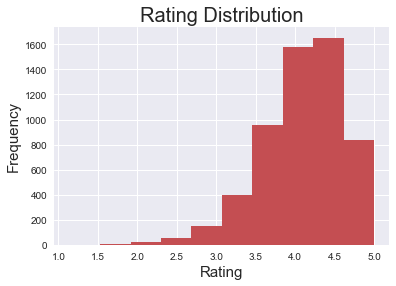

In [21]:
n_prod_review_df.groupby('asin')['overall'].mean().hist(color=color[2])
plt.xlabel('Rating',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Rating Distribution',fontsize=20)

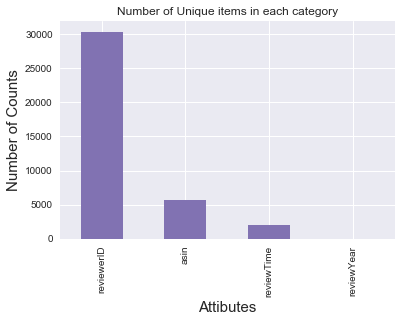

In [22]:
n_prod_review_df[['reviewerID','asin','reviewTime','reviewYear']].T.apply(lambda x: x.nunique(), axis=1).plot.bar(color=color[3])
plt.xlabel('Attibutes',fontsize=15)
plt.ylabel('Number of Counts',fontsize=15)
plt.title('Number of Unique items in each category')

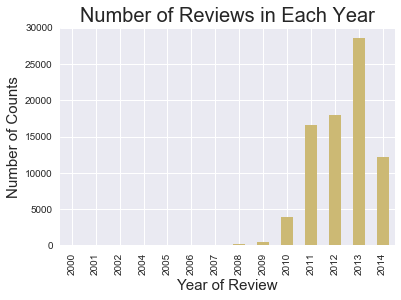

In [24]:
n_prod_review_df.groupby('reviewYear')['overall'].count().plot.bar(color=color[4])
plt.xlabel('Year of Review',fontsize=15)
plt.ylabel('Number of Counts',fontsize=15)
plt.title('Number of Reviews in Each Year',fontsize=20)

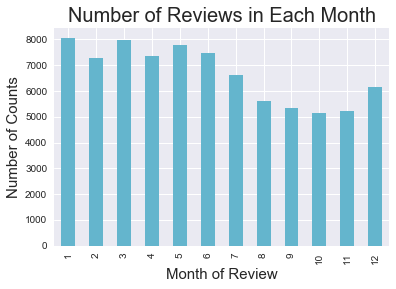

In [25]:
n_prod_review_df.groupby('reviewMonth')['overall'].count().plot.bar(color=color[5])
plt.xlabel('Month of Review',fontsize=15)
plt.ylabel('Number of Counts',fontsize=15)
plt.title('Number of Reviews in Each Month',fontsize=20)

# Scale-up in Spark

### data type
all = [ "DataType", "NullType", "StringType", "BinaryType", "BooleanType", "DateType", "TimestampType", "DecimalType", "DoubleType", "FloatType", "ByteType", "IntegerType", "LongType", "ShortType", "ArrayType", "MapType", "StructField", "StructType"]

In [21]:
from pyspark.sql.types import *

In [22]:
schema = StructType([StructField('overall', FloatType(), True),
                     StructField('unixReviewTime', IntegerType(), True),
                     StructField('reviewTime', StringType(), True)])
n_prod_review_rdd = sqlContext.createDataFrame(n_prod_review_df[['overall','unixReviewTime','reviewTime']],schema).rdd